# Pretraining on unlabelled data

## Installation

This notebook uses code from [elcapo/llm-from-scratch](https://github.com/elcapo/llm-from-scratch/). In order to use it:

```bash
git clone https://github.com/elcapo/llm-from-scratch
cd llm-from-scratch

python -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt

jupyter notebook
```

**Have fun!**

## Where were we?

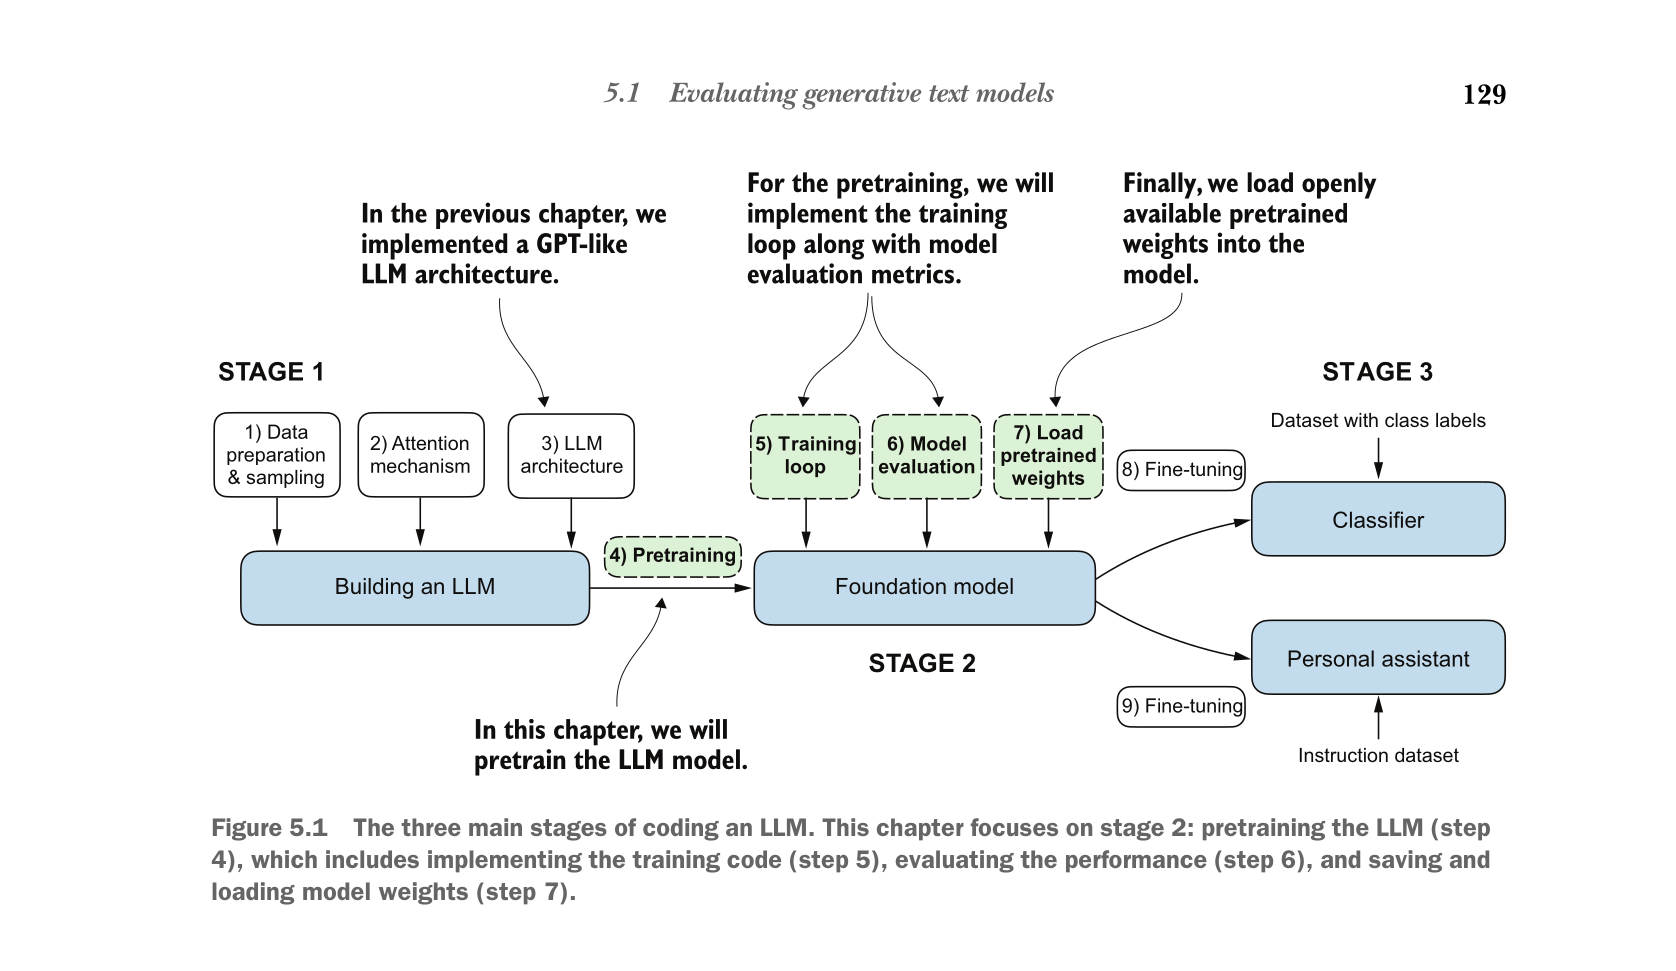

## Where are we going?

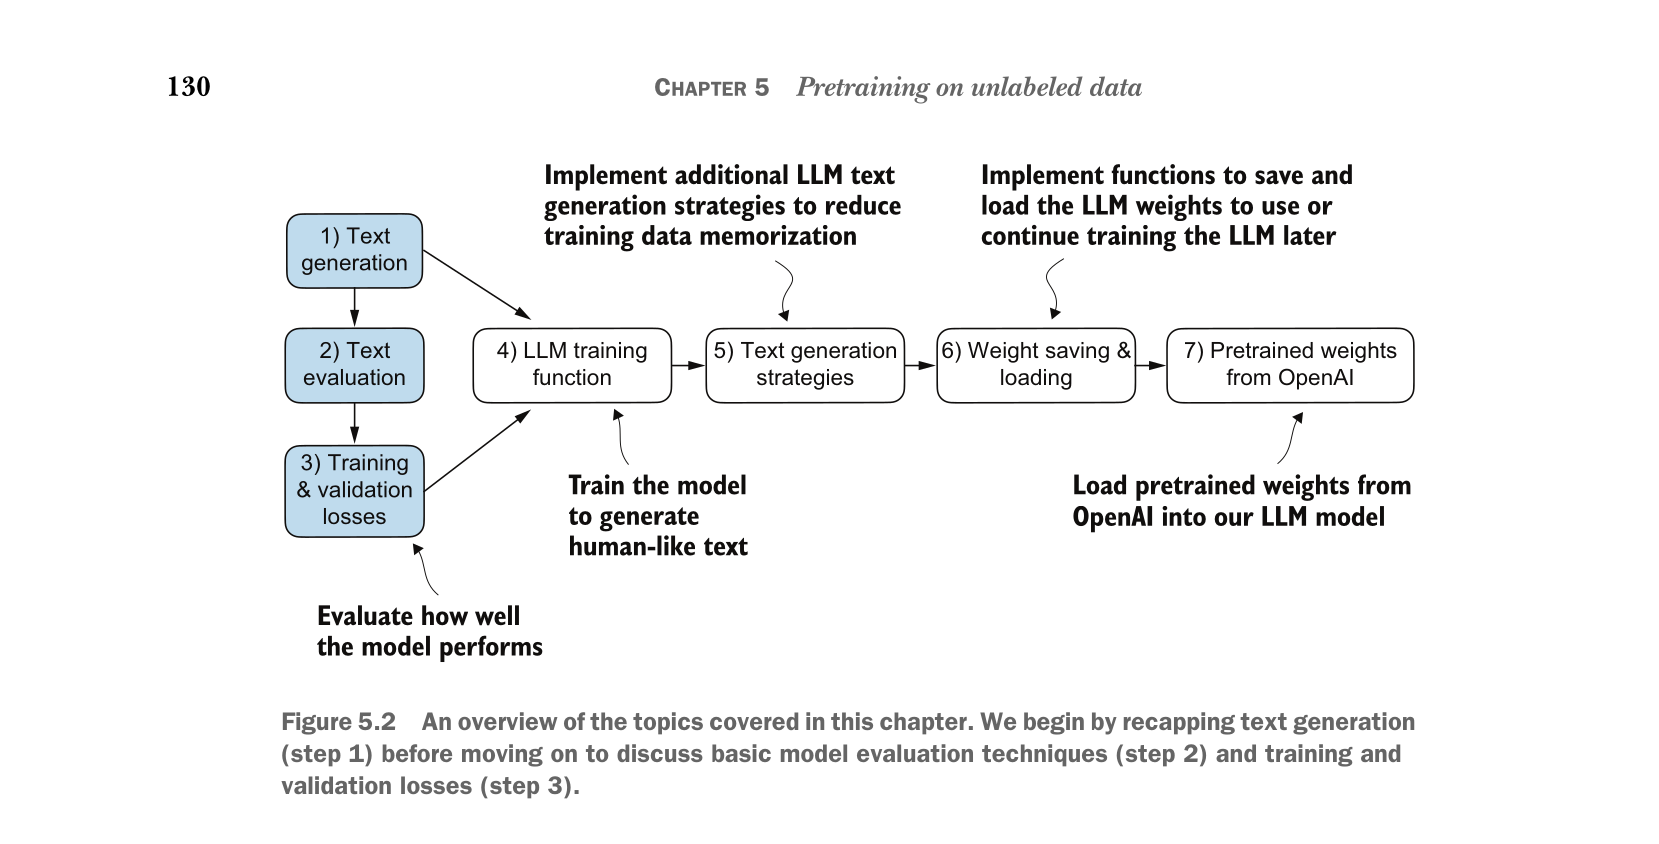

In [2]:
import matplotlib.pyplot as plt
import torch
import warnings

In [3]:
torch.manual_seed(123)
warnings.filterwarnings('ignore')

Let's prepare a tiny input and target to use it to test our model before we feed it with a "real" dataloader.

In [4]:
from scratch.tokenizers.tiktoken_tokenizer import TiktokenTokenizer

tokenizer = TiktokenTokenizer()

inputs = torch.cat(
    (
        tokenizer.text_to_tokens('every effort moves'),
        tokenizer.text_to_tokens('I really like')
    )
)

targets = torch.cat(
    (
        tokenizer.text_to_tokens(' effort moves you'),
        tokenizer.text_to_tokens(' really like chocolate')
    )
)

### Sources
- [scratch/tokenizers/tiktoken_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/tiktoken_tokenizer.py)
- [scratch/tokenizers/base_tokenizer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/tokenizers/base_tokenizer.py)

Now, we instantialte a model with the settings of a GPT2 "small" and reduce its context lenght to make it easier for our computer to handle it. We'll set it back to it's original value when we load OpenAI's weights.

In [5]:
from scratch.gpt_config import GptConfig
from scratch.gpt_model import GptModel

config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

### Sources
- [scratch/gpt_config.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_config.py)
- [scratch/gpt_model.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/gpt_model.py)

We can now get the answer to process our inputs.

In [6]:
with torch.no_grad():
    logits = model(inputs)

### References

- [torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

We are using softmax here because we'll use it to make the model to generate different outputs considering a "temperature" setting.

In [7]:
probas = torch.softmax(logits, dim=-1)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)

### References

- [torch.nn.Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- [torch.argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)

But, for the moment, we could obtain the same result without the softmax normalization.

In [8]:
token_ids = torch.argmax(logits, dim=-1, keepdim=True)

Anyway, let's get check the generated text.

In [9]:
for sample_id, target in enumerate(targets):
    print("")
    print("Sample:", sample_id + 1)
    print("- Input:", tokenizer.tokens_to_text(inputs[sample_id]))
    print("- Target:", tokenizer.tokens_to_text(target))
    print("- Output:", tokenizer.tokens_to_text(token_ids[sample_id].flatten()))


Sample: 1
- Input: every effort moves
- Target:  effort moves you
- Output:  astounding Gad applic

Sample: 2
- Input: I really like
- Target:  really like chocolate
- Output:  diagonal Swords allows


### References

- [torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html)

In [10]:
for sample_id, target in enumerate(targets):
    log_probas = torch.log(probas[sample_id, [0, 1, 2], targets[sample_id]])
    print("")
    print("Sample:", sample_id + 1)
    print("- Logits:", logits[sample_id, [0, 1, 2], targets[sample_id]].tolist())
    print("- Probabilities:", probas[sample_id, [0, 1, 2], targets[sample_id]].tolist())


Sample: 1
- Logits: [-0.21120132505893707, 1.3854831457138062, -0.8993706107139587]
- Probabilities: [1.365970638289582e-05, 6.713520997436717e-05, 6.8525569076882675e-06]

Sample: 2
- Logits: [-0.7834552526473999, -0.3723931610584259, -0.6096072793006897]
- Probabilities: [7.715892934356816e-06, 1.1614359209488612e-05, 9.19272133614868e-06]


In [11]:
def plot_probabilities(sample_id):
    fig, ax = plt.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    x = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in targets[sample_id]]
    y = probas[sample_id, [0, 1, 2], targets[sample_id]].tolist()
    
    ax.bar(x, y, color='green')
    ax.set_title('Probabilities before training for sample ' + str(sample_id + 1))
    fig.show()

### References

- [torch.unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)

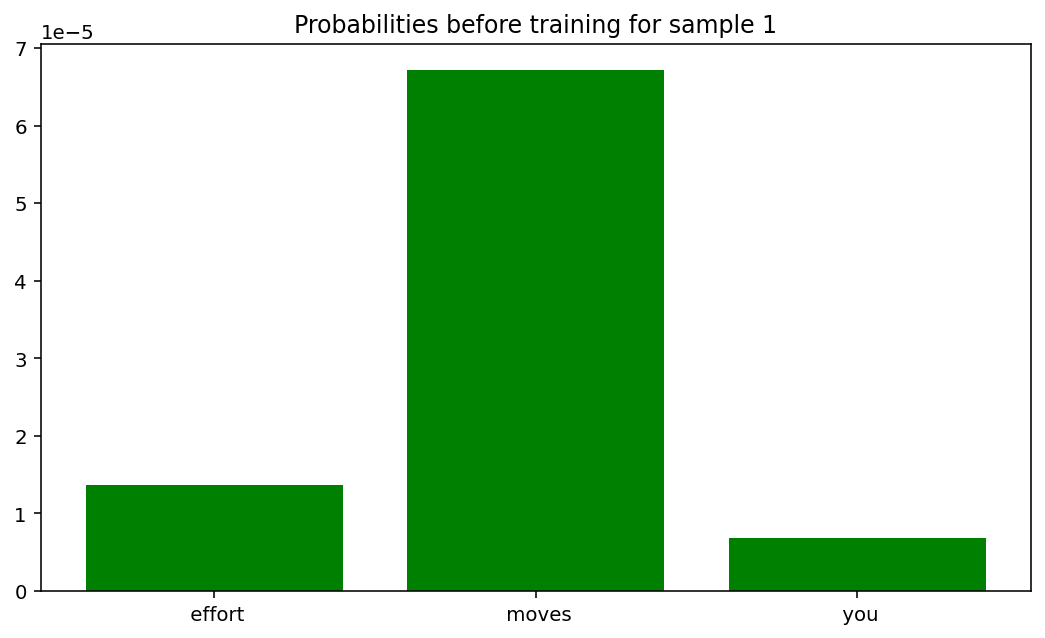

In [12]:
plot_probabilities(sample_id=0)

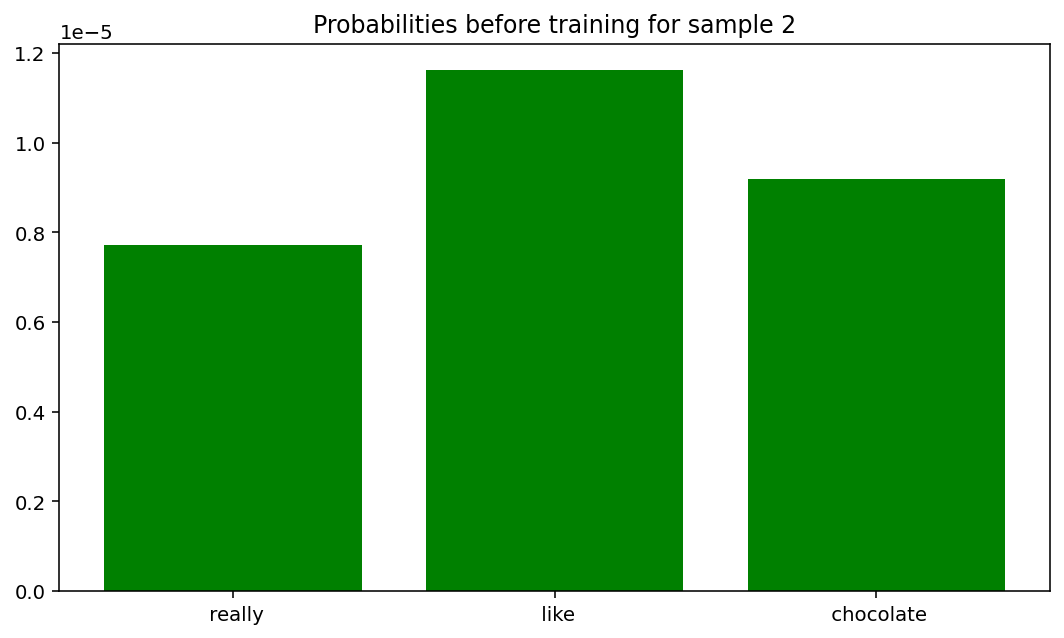

In [13]:
plot_probabilities(sample_id=1)

In [14]:
def plot_contextualized_probabilities(sample_id):
    fig, ax = plt.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    batch_tokens = targets[sample_id]
    other_tokens = torch.randint(0, config.vocab_size - 1, (33,))
    tokens = batch_tokens.tolist() + other_tokens.tolist()

    batch_words = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in batch_tokens]
    other_words = [tokenizer.tokens_to_text(token.unsqueeze(0).unsqueeze(0)) for token in other_tokens]
    words = batch_words + other_words
    
    batch_probas = probas[sample_id, [0, 1, 2], batch_tokens].tolist()
    other_probas = probas[sample_id, 0, other_tokens].tolist()
    y = batch_probas + other_probas

    batch_color = ['green' for _ in batch_words]
    other_color = ['red' for _ in other_words]
    c = batch_color + other_color
    
    ax.bar(words, y, color=c)
    ax.set_title('Probabilities before training for sample ' + str(sample_id + 1))
    ax.set_xticklabels(words, rotation=75)
    fig.show()

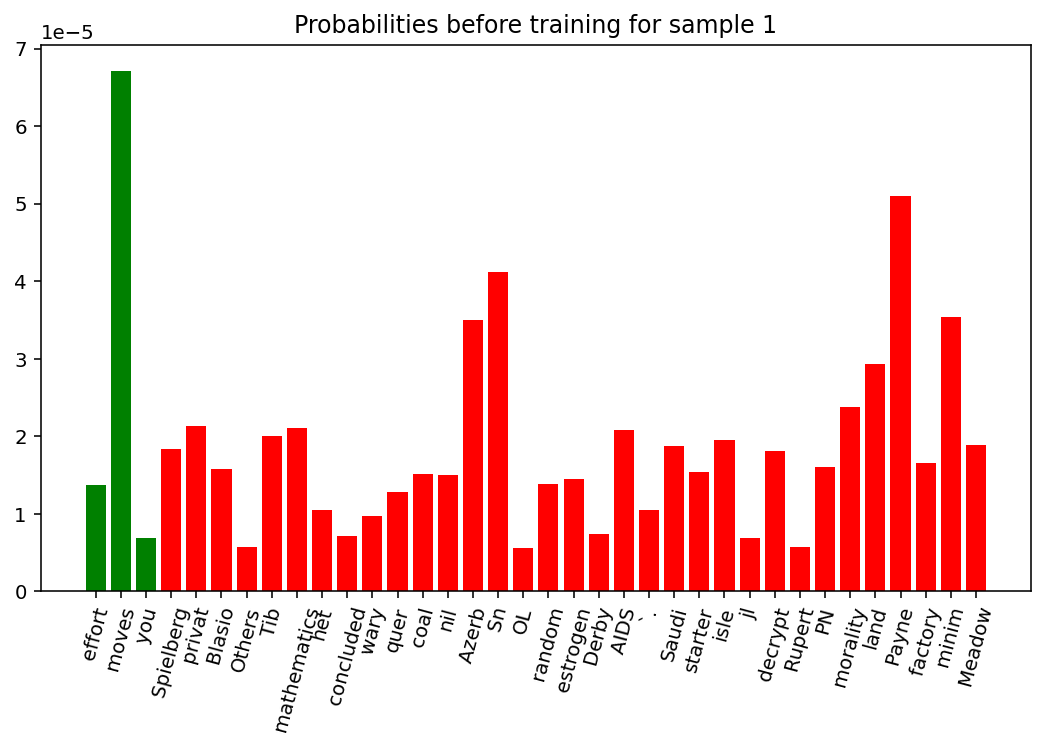

In [15]:
plot_contextualized_probabilities(sample_id=0)

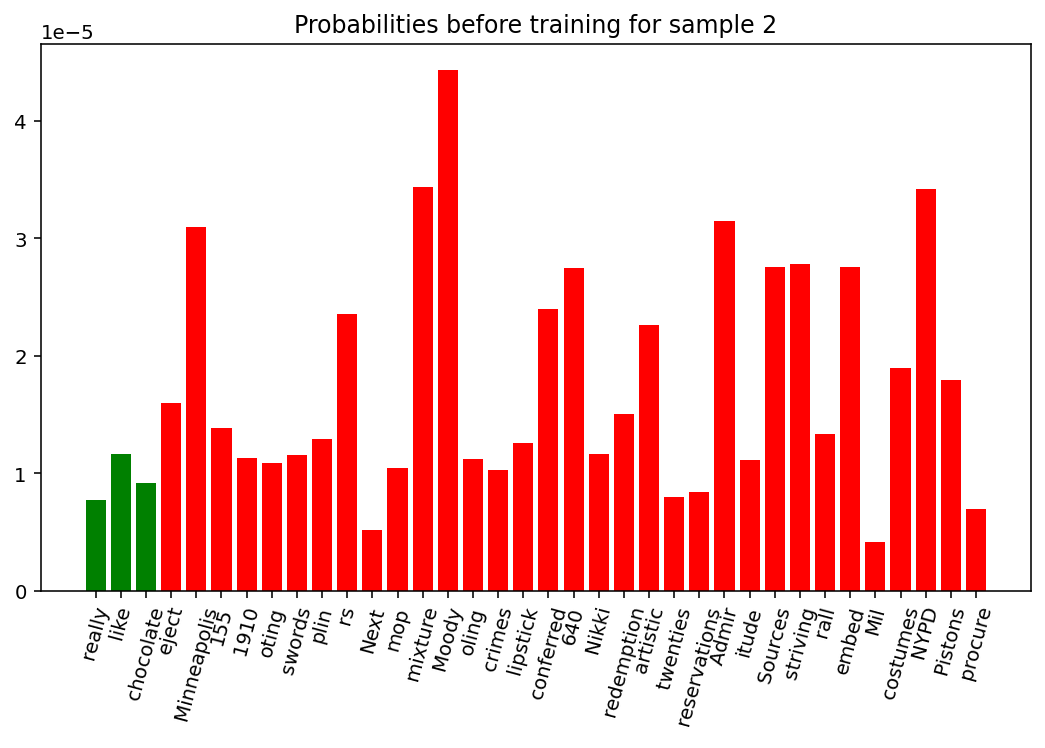

In [16]:
plot_contextualized_probabilities(sample_id=1)

## Text evaluation

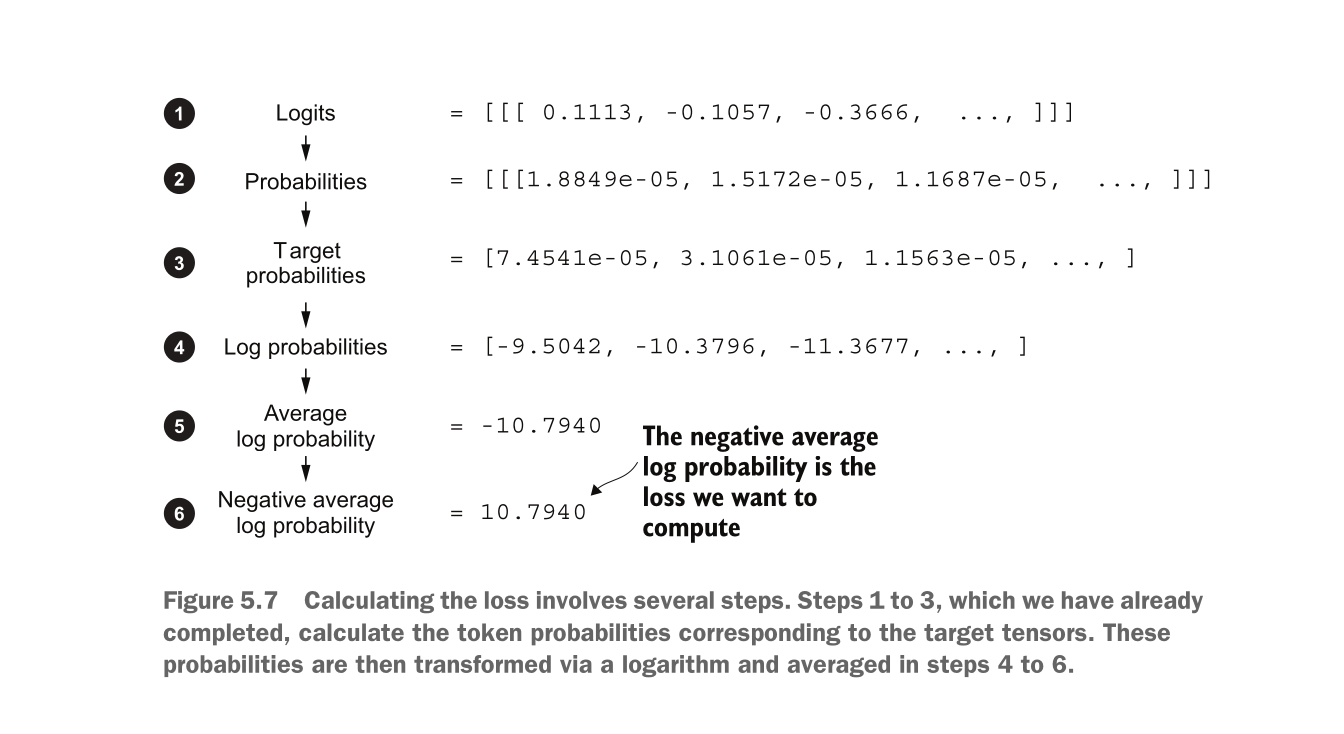

In [17]:
def print_loss(sample_id):
    batch_probas = probas[sample_id, [0, 1, 2], targets[sample_id]]
    log_probas = torch.log(batch_probas)
    print()
    print("Sample:", sample_id + 1)
    print("- Logits:", logits[sample_id, [0, 1, 2], targets[sample_id]].tolist())
    print("- Probabilities:", probas[sample_id, [0, 1, 2], targets[sample_id]].tolist())
    print("- Logarithm of the probabilities:", log_probas)
    print("- Average of the logarithm", torch.mean(log_probas))
    print("- Negative average of the logarithm", -torch.mean(log_probas))

print_loss(sample_id=0)
print_loss(sample_id=1)

print()
print("Overall:")

all_probas = torch.cat(
    (
        probas[0, [0, 1, 2], targets[0]],
        probas[1, [0, 1, 2], targets[1]]
    )
)

all_log_probas = torch.log(all_probas)

print("- Probabilities:", all_probas)
print("- Logarithm of the probabilities:", all_log_probas)
print("- Average of the logarithm", torch.mean(all_log_probas))
print("- Negative average of the logarithm", -torch.mean(all_log_probas))


Sample: 1
- Logits: [-0.21120132505893707, 1.3854831457138062, -0.8993706107139587]
- Probabilities: [1.365970638289582e-05, 6.713520997436717e-05, 6.8525569076882675e-06]
- Logarithm of the probabilities: tensor([-11.2011,  -9.6088, -11.8909])
- Average of the logarithm tensor(-10.9003)
- Negative average of the logarithm tensor(10.9003)

Sample: 2
- Logits: [-0.7834552526473999, -0.3723931610584259, -0.6096072793006897]
- Probabilities: [7.715892934356816e-06, 1.1614359209488612e-05, 9.19272133614868e-06]
- Logarithm of the probabilities: tensor([-11.7722, -11.3633, -11.5971])
- Average of the logarithm tensor(-11.5775)
- Negative average of the logarithm tensor(11.5775)

Overall:
- Probabilities: tensor([1.3660e-05, 6.7135e-05, 6.8526e-06, 7.7159e-06, 1.1614e-05, 9.1927e-06])
- Logarithm of the probabilities: tensor([-11.2011,  -9.6088, -11.8909, -11.7722, -11.3633, -11.5971])
- Average of the logarithm tensor(-11.2389)
- Negative average of the logarithm tensor(11.2389)


### References

- [torch.log](https://pytorch.org/docs/stable/generated/torch.log.html)
- [torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html)
- [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html)

In [18]:
torch.nn.functional.cross_entropy(logits.flatten(0, 1), targets.flatten())

tensor(11.2389)

### References

- [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

Sounds good but...
- Why are we taking a logarithm?
- Why are we computing an average?
- Why are we switching the sign?

### Logistic regression

Given $h(x)$ as the last activation function, we want a function that separates the "right" values and "wrong" ones, like this:

$$
  P(y|\boldsymbol{x}) = \left\{\def\arraystretch{1.2}%
  \begin{array}{@{}c@{\quad}l@{}}
    h(\boldsymbol{x}) & y = 1 \\
    1 - h(\boldsymbol{x}) & y = 0 \\
  \end{array}\right.
$$

A function that satisfies that, is:

$$
P(y|\boldsymbol{x}) = h(\boldsymbol{x})^y · (1 - h(\boldsymbol{x}))^{1 - y}
$$

For multiple training examples, we want to maximize their overall probability.

As those are independent events, their probabilities multiply:

$$
P(y_1, ..., y_n | \boldsymbol{x}_i, ..., \boldsymbol{x}_n) = \prod_{i=1}^n P(y_i | \boldsymbol{x}_i)
$$

Which is the same as maximizing its logarithm, only that with the logarithm we have to maximise an addition rather than a multiplication.

We added a negative sign because PyTorch comes bundled with functions to minimize gradients.

$$
\mathcal{L} = - \sum_{i=1}^{n} y_i · log(p_i)
$$

Since only the correct tokens contribute to the addition (as $y_i = 0$ for the other ones), the expression can be simplified to:

$$
\mathcal{L} = - log(p_y)
$$

Finally, for a sequence of tokens, the loss is computed as the average or sum of the cross-entropy losses for all predicted tokens in the sequence:

$$
\mathcal{L}_{seq} = \frac{1}{n} \sum_{i=1}^{n} - log(p_{y_i})
$$

#### Sources
- [Logistic Regression Loss Function](https://www.youtube.com/watch?v=GxJe0DZvydM) by Sebastian Raschka (2021)

## Calculating the training and validation losses

Now, to start preparing a real data loader, let's read "The Veredict".

In [19]:
file_path = "tests/fixtures/the-veredict.txt"
with open(file_path, "r", encoding="utf-8") as f:
    text_data = f.read()

print("Total characters", len(text_data))
print("Total tokens", len(tokenizer.encode(text_data)))

Total characters 20480
Total tokens 5146


... and let's split it into two training and validation sets.

In [20]:
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))

train_data = text_data[:split_idx]
validation_data = text_data[split_idx:]

Now, we'll use it to feed the dataloader from chapter 2.

In [21]:
from scratch.dataloader import create_dataloader

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=True,
    shuffle=True,
    num_workers=0)

validation_loader = create_dataloader(
    validation_data,
    batch_size=2,
    max_length=config.context_length,
    stride=config.context_length,
    drop_last=False,
    shuffle=False,
    num_workers=0)

### Sources

- [scratch/dataloader.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/dataloader.py)

In [22]:
print("Train loader")
for x, y in train_loader:
    print("- ", x.shape, y.shape)

print("")
print("Validation loader")
for x, y in validation_loader:
    print("- ", x.shape, y.shape)

Train loader
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])
-  torch.Size([2, 256]) torch.Size([2, 256])

Validation loader
-  torch.Size([1, 256]) torch.Size([1, 256])


Let's now check how our untrained model performs.

In [23]:
from scratch.training.loader_loss import LoaderLoss

loader_loss = LoaderLoss(model)

with torch.no_grad():
    train_loss = loader_loss.calc(train_loader)
    validation_loss = loader_loss.calc(validation_loader)

print("Training loss", train_loss)
print("Validation loss", validation_loss)

Training loss 10.996612310409546
Validation loss 10.976768493652344


### Sources

- [scratch/training/batch_loss.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/batch_loss.py)
- [scratch/training/loader_loss.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/loader_loss.py)

## Training an LLM

First let's intantiate an optimizer, which is what will take care of updating the model weights whenever we calculate loss.

In [24]:
# Instantiate the model here to reinitiate its weights every time this cell is executed
config = GptConfig.small()
config.context_length = 256
config.qkv_bias = False

model = GptModel(config)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr = 0.0004,
    weight_decay = 0.1)

Now, let's instantiate our trainer.

In [25]:
from scratch.training.simple_trainer import SimpleTrainer

trainer = SimpleTrainer(
    model,
    train_loader,
    validation_loader,
    optimizer,
    tokenizer)

### References

- [torch.optim.AdamW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html)

### Sources

- [scratch/training/simple_trainer.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/training/simple_trainer.py)

Finally! This is what we are here for! Let's train our model.

In [26]:
num_epochs = 10

train_losses, validation_losses, tokens_seen = trainer.train(
    num_epochs = num_epochs,
    eval_freq = 5,
    eval_iter = 5,
    start_context = "Every effort moves you")

Epoch 1
- Step 0
- Train loss 9.752584838867188
- Evaluation loss 10.204134941101074
Epoch 1
- Step 5
- Train loss 8.054945182800292
- Evaluation loss 8.311410903930664
Every effort moves you,, the.                                              
Epoch 2
- Step 10
- Train loss 6.776452732086182
- Evaluation loss 7.066651344299316
Epoch 2
- Step 15
- Train loss 5.998719882965088
- Evaluation loss 6.608098030090332
Every effort moves you, the, the the, the the the the the, the the the, the the the, the, the, the the the, the, the, the the the, the the the the, the, the the, the, the the
Epoch 3
- Step 20
- Train loss 5.780086421966553
- Evaluation loss 6.510787010192871
Every effort moves you""    " and I had"I.  ". "I and I had"I was.   "--"--"I.      "--"--"--"
Epoch 4
- Step 25
- Train loss 5.580791187286377
- Evaluation loss 6.436972618103027
Epoch 4
- Step 30
- Train loss 5.084748649597168
- Evaluation loss 6.354556083679199
Every effort moves you of the of the of the of the of the of

In [27]:
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_looses, validation_looses):
    fig, ax1 = plt.subplots(figsize=(5,3))

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    ax1.plot(epochs_seen, train_looses, label="Training loss")
    ax1.plot(epochs_seen, validation_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

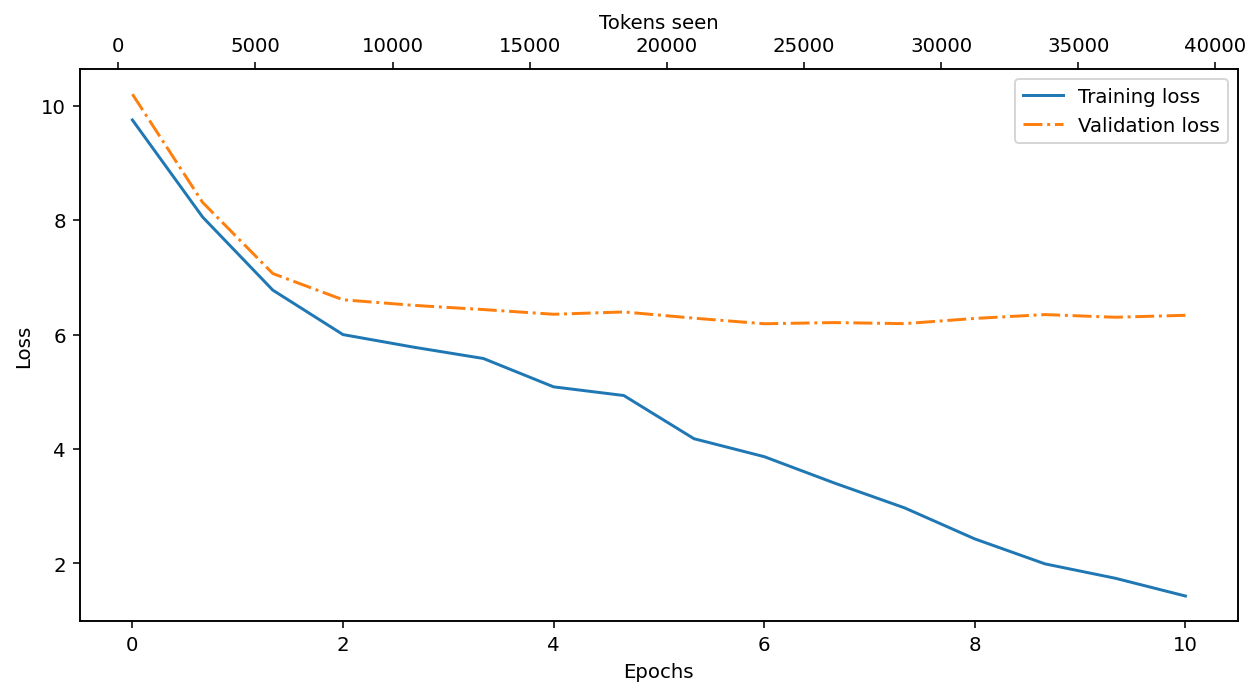

In [28]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, validation_losses)

## Decoding strategies to control randomness

For a given pretrained model, we'd always obtain the same output if we executed this several times:

In [29]:
from scratch.generators.simple_text_generator import SimpleTextGenerator

inputs = tokenizer.text_to_tokens("Every effort moves you").to("cuda")
generator = SimpleTextGenerator(model, max_new_tokens=25)
logits = generator.generate(inputs)
output = tokenizer.tokens_to_text(logits)

print("Output:", output)

Output: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




### Sources

- [scratch/generators/simple_text_generator.py](https://github.com/elcapo/llm-from-scratch/blob/main/scratch/generators/simple_text_generator.py)

This is a simpler example show casing the same thing. We'll always obtain "forward":

In [30]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}
next_token_logits = torch.tensor([4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79])
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

print(inverse_vocab[next_token_id])

forward


In [31]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(freq.item(), "->", inverse_vocab[i])

def plot_probas(probas, words, title, color='green'):
    fig, ax = plt.subplots()

    fig.set_figwidth(9)
    fig.set_figheight(5)
    fig.set_dpi(142)

    x = torch.arange(len(words))
    ax.bar(x, probas, color=color)
    ax.set_title(title)
    ax.set_ylabel('Probability')
    ax.set_xticks(x)
    ax.set_xticklabels(words, rotation=75)
    fig.show()

### References

- [torch.multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html)
- [torch.bincount](https://pytorch.org/docs/stable/generated/torch.bincount.html)

### Temperature scaling

We'll now see how we can tweak the softmax function to make it help us getting different results each time.

In [32]:
def softmax_with_temperature(logits, temperature = 1):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

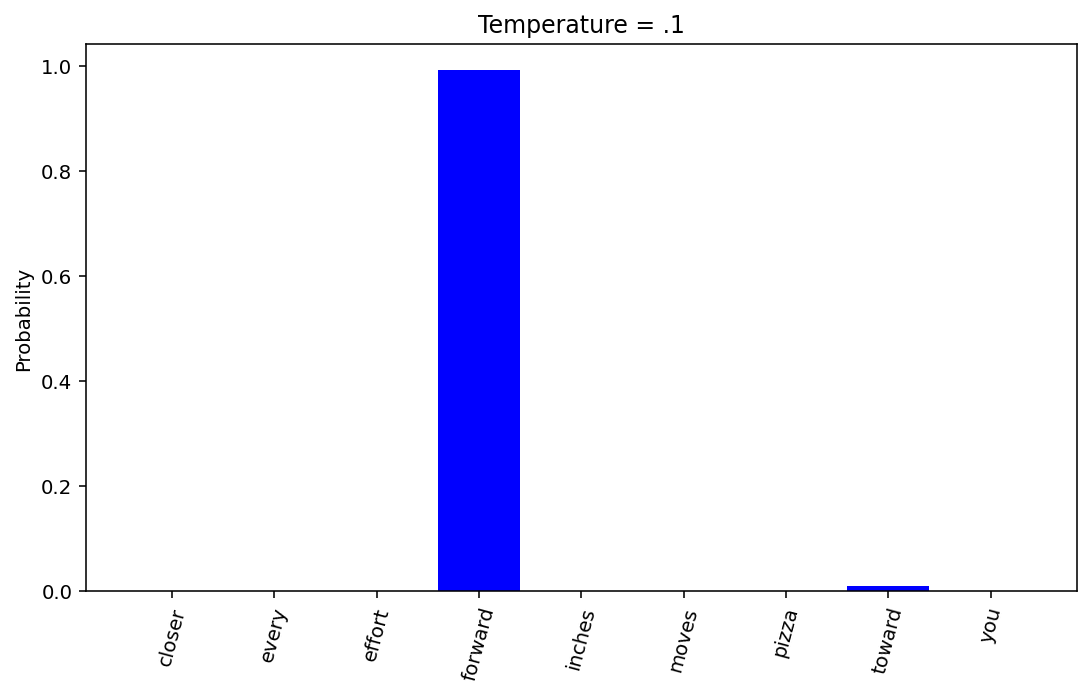

In [33]:
plot_probas(
    softmax_with_temperature(next_token_logits, .1),
    vocab.keys(),
    "Temperature = .1",
    "blue"
)

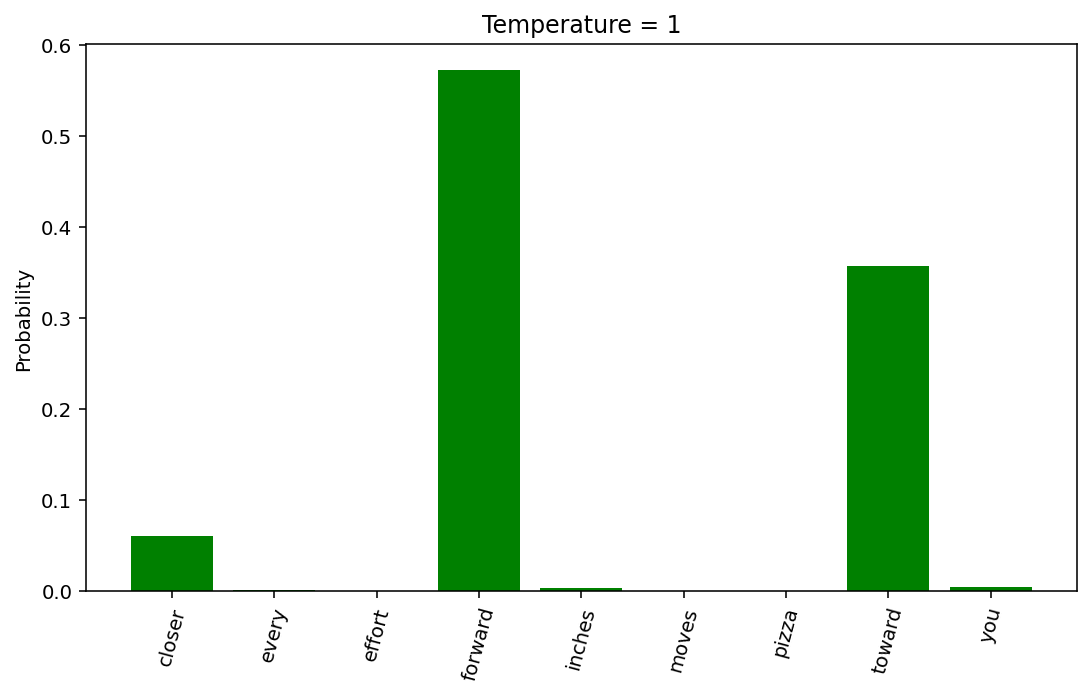

In [34]:
plot_probas(
    softmax_with_temperature(next_token_logits, 1),
    vocab.keys(),
    "Temperature = 1",
    "green"
)

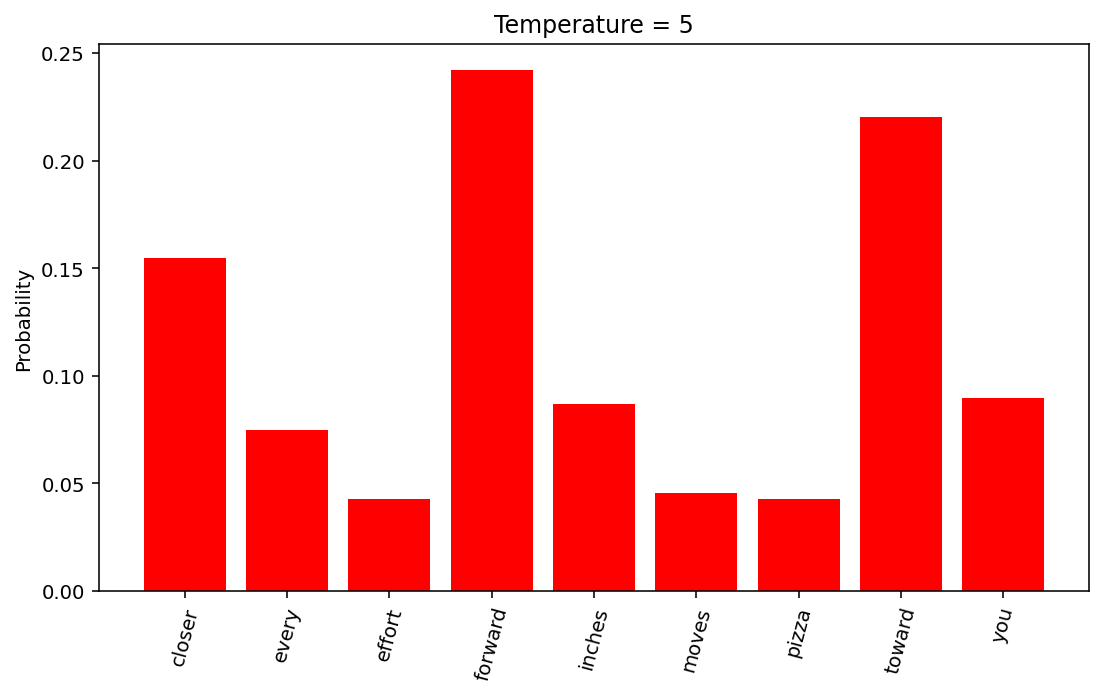

In [35]:
plot_probas(
    softmax_with_temperature(next_token_logits, 5),
    vocab.keys(),
    "Temperature = 5",
    "red"
)

### Top-k sampling

In combination with temperature scaling, top-k sampling can enrich our text generation.

In [36]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)
print("Top 3 words:", [inverse_vocab[pos.item()] for pos in top_pos])

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
Top 3 words: ['forward', 'toward', 'closer']


### Reference

- [torch.topk](https://pytorch.org/docs/main/generated/torch.topk.html)

In [40]:
from scratch.generators.probabilistic_text_generator import ProbabilisticTextGenerator

inputs = tokenizer.text_to_tokens("Every effort moves you").to("cuda")
generator = ProbabilisticTextGenerator(model, max_new_tokens=25, top_k=25, temperature=1.4)

for _ in range(10):
    logits = generator.generate(inputs)
    output = tokenizer.tokens_to_text(logits)
    print("-", output)

- Every effort moves you ever the Riv's tears at."

"I made a. The I had was growing--as!!, I
- Every effort moves you know terr was, so one of. It to the irony; and in an added Jack of that, on the current the
- Every effort moves you know," was my own that." by's the--that inevitably the Riv--and have picture--and by was dead picture
- Every effort moves you thought Jack I one of the ax, which--and to had She of a self-cl to's past!


- Every effort moves you sun she?" G."
"Ah one of the reason of the Sev charming, he turned never thought Jack had always to
- Every effort moves you?"


In the ax down the--so he had always she up all I had been deadoustache, I
- Every effort moves you get him to put it pictures by?He stood, to be single one had not to the moment I have up and I
- Every effort moves you?"
A. . I had to I don't _rose She. I had that he was his eyes upmer something
- Every effort moves you stand to her my eyes grew, as it were, you say on Jackity. The till nearly a's! Fo